## Autoencoders

Examples and useful reading:
- https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb
- https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
- https://github.com/Fraser-Greenlee/T5-VAE

Datasets:
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://lionbridge.ai/datasets/20-best-image-datasets-for-computer-vision/

The following autoencoder was trained on the Visual Genome dataset of 40k+ images of various sizes.
Using PyTorch transformers we can bootstrap the dataset by flipping the images, adding random noise, etc.

This workbook is basically a scratch pad for iterating on a simple auto encoder for use in upcoming projects within this repo. In theory it'll be used as a pre-processor for things like image labeling and in reinforcement learning for games. The idea is that by compressing the image via the encoder network in a way that preserves important structure we can reduce the size and/or training time of downstream networks.

In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import math

from data.visual_genome import VisualGenomeDataset
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

from encoders import cnn

# filter the annoying warnings
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = cnn.AutoEncoder(3, mid_channels=16)
crops = [
#     (320, 400),
    (400,400),
    (240,240),
#     (240,320),
    (400,240)
]
# model.to(torch.device('cpu'))
for crop in crops:
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(500),
        transforms.RandomCrop(crop),
        transforms.ToTensor(),
    ])

    data = VisualGenomeDataset('./data/images/1', transform=transform)
    print('img: ', data[0].shape)
    print('rec:', model(data[0].unsqueeze(0)).shape)
    print('')

img:  torch.Size([3, 400, 400])
rec: torch.Size([1, 3, 400, 400])

img:  torch.Size([3, 240, 240])
rec: torch.Size([1, 3, 240, 240])

img:  torch.Size([3, 400, 240])
rec: torch.Size([1, 3, 400, 240])



In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(500),
    transforms.RandomCrop((400,400)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
])

data = VisualGenomeDataset('./data/images/1', transform=transform)
train, val = random_split(data, [40000, 3649])

In [74]:
model = cnn.AutoEncoder.load_from_checkpoint('./dist/cnn-ltng.pt', input_channels=3, mid_channels=16)

In [75]:
trainer = pl.Trainer(max_epochs=20, auto_lr_find=True, gpus=1, accumulate_grad_batches=3, precision=16, default_root_dir='./checkpoints/', gradient_clip_val=0.6)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [76]:
trainer.fit(model, DataLoader(train, batch_size=200, num_workers=4), DataLoader(val, batch_size=50, num_workers=4))


  | Name    | Type       | Params
---------------------------------------
0 | encoder | ModuleList | 9 K   
1 | decoder | ModuleList | 10 K  


Epoch 18:  62%|██████▏   | 123/200 [01:40<01:03,  1.22it/s, loss=0.004, v_num=7]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([1, 3, 76, 118])
orig shape torch.Size([3, 333, 500])
recon shape torch.Size([3, 332, 500])


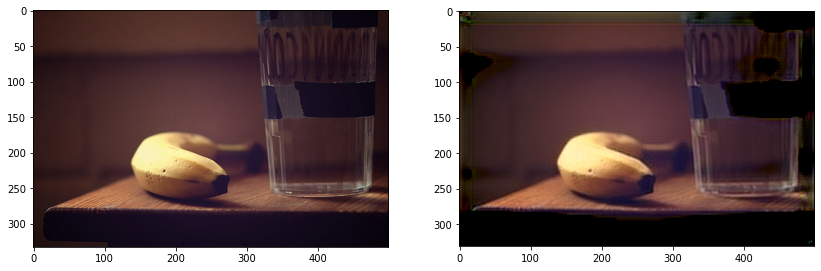

In [81]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])

data = VisualGenomeDataset('./data/images/1', transform=transform)
i = data[170]
model.eval()
model.to(torch.device('cpu'))

z = i.unsqueeze(0)
for layer in model.encoder:
    z = layer(z)

print(z.shape)

recon = model(i.permute(0,1,2).unsqueeze(0).float())
z = z.unsqueeze(0).float().detach()[0]
recon = recon.detach()[0]
print('orig shape', i.shape)
print('recon shape', recon.shape)

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(i.permute(1,2,0))
axarr[1].imshow(recon.permute(1,2,0))
# axarr[2].imshow(z[0].permute(1,2,0))

In [82]:
trainer.save_checkpoint("./dist/cnn-ltng.pt")

In [83]:
model.decoder

ModuleList(
  (0): Sequential(
    (0): ConvTranspose2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(8, 8), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)